In [19]:
import os
os.chdir('molanalysis')

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'molanalysis'

In [ ]:
# -*- coding: utf-8 -*-
"""
This script analyzes neural and behavioral data in a multi-area calcium imaging
dataset with labeled projection neurons. The visual stimuli are natural images.
Matthijs Oude Lohuis, 2023, Champalimaud Center
"""

# %% # Imports
# Import general libs
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

# Set working directory to root of repo
current_path = os.getcwd()
# Identify if path has 'molanalysis' as a folder in it
if 'molanalysis' in current_path:
    # If so, set the path to the root of the repo
    current_path = current_path.split('molanalysis')[0] + 'molanalysis'
else:
    raise FileNotFoundError(
        f'This needs to be run somewhere from within the molanalysis folder, not {current_path}')
os.chdir(current_path)
sys.path.append(current_path)

from sensorium_utility_training_read_config import read_config

run_config = read_config('../Petreanu_MEI_generation/run_config.yaml') # Must be set

RUN_NAME = run_config['RUN_NAME'] # MUST be set. Creates a subfolder in the runs folder with this name, containing data, saved models, etc. IMPORTANT: all values in this folder WILL be deleted.

keep_behavioral_info = run_config['data']['keep_behavioral_info']
area_of_interest = run_config['data']['area_of_interest']
sessions_to_keep = run_config['data']['sessions_to_keep']
OUTPUT_NAME = run_config['data']['OUTPUT_NAME']
INPUT_FOLDER = run_config['data']['INPUT_FOLDER']
OUTPUT_FOLDER = f'../molanalysis/MEI_generation/data/{OUTPUT_NAME}' # relative to molanalysis root folder

# os.chdir('../')  # set working directory to the root of the git repo

# Import personal lib funcs
from loaddata.session_info import load_sessions
from utils.plotting_style import *  # get all the fixed color schemes
from utils.imagelib import load_natural_images
from loaddata.get_data_folder import get_local_drive
from utils.pair_lib import compute_pairwise_anatomical_distance
from utils.rf_lib import *

savedir = os.path.join(f'../Petreanu_MEI_generation/runs/{RUN_NAME}/Plots/RF_analysis')
os.makedirs(savedir, exist_ok=True)

# %% Load IM session with receptive field mapping ################################################

# test if folders already defined 
try: 
    folders
except NameError:
    # First level
    folders = [os.path.join(INPUT_FOLDER, name) for name in os.listdir(
        INPUT_FOLDER) if os.path.isdir(os.path.join(INPUT_FOLDER, name)) and not "merged_data" in name]
    folders = [x.replace("\\", "/") for x in folders]
    # Second level
    files = [[folder, os.path.join(folder, name).replace('\\', '/')] for folder in folders for name in os.listdir(
        folder) if os.path.isdir(os.path.join(folder, name)) and not "merged_data" in name]
    # only get last value after /
    session_list = [[folder.split("/")[-1], name.split("/")[-1]]
                    for folder, name in files]

    # drop ['LPE10919', '2023_11_08'] because the data is not converted yet
    session_list = [x for x in session_list if x != ['LPE10919', '2023_11_08']]
    print(session_list)

if sessions_to_keep != 'all':
    session_list = [x for x in session_list if x in sessions_to_keep]


session_list = np.array([['LPE10885', '2023_10_20']])
# Load sessions lazy: (no calciumdata, behaviordata etc.,)
sessions, nSessions = load_sessions(protocol='IM', session_list=session_list, data_folder = INPUT_FOLDER)


#%% 
for ises in range(nSessions):    # Load proper data and compute average trial responses:
    sessions[ises].load_respmat(calciumversion='deconv', keepraw=False)


[['LPE09665', '2023_03_20'], ['LPE10883', '2023_10_23'], ['LPE10883', '2023_10_31'], ['LPE10884', '2023_10_12'], ['LPE10885', '2023_10_20'], ['LPE10919', '2023_11_09'], ['LPE11086', '2023_12_16'], ['LPE11086', '2024_01_09'], ['LPE11495', '2024_02_29'], ['LPE11998', '2024_05_08'], ['LPE12223', '2024_06_11']]


Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

In [9]:

#%% Interpolation of receptive fields:
sessions = compute_pairwise_anatomical_distance(sessions)
sessions = smooth_rf(sessions,radius=75,rf_type='Fneu')
sessions = exclude_outlier_rf(sessions) 
sessions = replace_smooth_with_Fsig(sessions) 

Computing pairwise anatomical distance for each session: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]
Smoothed interpolation of missing RF:   0%|          | 0/1 [00:00<?, ?it/s]

Index(['iscell', 'iscell_prob', 'skew', 'radius', 'npix_soma', 'npix', 'xloc', 'yloc', 'redcell', 'frac_of_ROI_red', 'frac_red_in_ROI', 'chan2_prob', 'nredcells', 'plane_idx', 'roi_idx', 'plane_in_roi_idx', 'roi_name', 'depth', 'power_mw', 'labeled', 'arealabel', 'rf_az_F_old', 'rf_el_F_old', 'rf_sx_F', 'rf_sy_F', 'rf_r2_F', 'rf_az_Fneu', 'rf_el_Fneu', 'rf_sx_Fneu', 'rf_sy_Fneu', 'rf_r2_Fneu', 'rf_az_Fsmooth', 'rf_el_Fsmooth', 'rf_sx_Fsmooth', 'rf_sy_Fsmooth', 'rf_r2_Fsmooth', 'meanF', 'meanF_chan2', 'noise_level', 'event_rate', 'cell_id', 'layer', 'recombinase', 'session_id', 'rf_az_F',
       'rf_el_F', 'rf_sz_F', 'rf_p_F'],
      dtype='object')


Setting outlier RFs to NaN: 100%|██████████| 1/1 [00:00<00:00, 121.30it/s]


In [16]:


#%% Load the output of digital twin model:
if area_of_interest == 'V1':
    statsfile_V1        = f'../Petreanu_MEI_generation/runs/{RUN_NAME}/results/neuron_stats.csv'
    statsdata_V1        = pd.read_csv(statsfile_V1)	
elif area_of_interest == 'PM':
    statsfile_PM        = f'../Petreanu_MEI_generation/runs/{RUN_NAME}/results/neuron_stats.csv'
    statsdata_PM        = pd.read_csv(statsfile_PM)

try:
    statsdata_V1        = pd.read_csv(statsfile_V1)	
except:
    statsdata_V1        = pd.DataFrame(columns=['cell_id','mean'])

try:
    statsdata_PM        = pd.read_csv(statsfile_PM)
except:
    statsdata_PM        = pd.DataFrame(columns=['cell_id','mean'])

ises                = 0
statsdata           = pd.concat([statsdata_V1,statsdata_PM]).reset_index(drop=True)

g               = statsdata['mean'].apply(lambda x: x.replace('   ',' ').replace('  ',' ').replace('[ ','').replace(' ]','').replace('[','').replace(']','').split(' '))
g               = np.array(list(g), dtype=float)

mergedata       = pd.DataFrame(data=g,columns=['rf_az_Ftwin','rf_el_Ftwin'])

In [12]:
sessions[0].celldata

,iscell,iscell_prob,skew,radius,npix_soma,npix,xloc,...,layer,recombinase,session_id,rf_az_F,rf_el_F,rf_sz_F,rf_p_F
0,1.0,0.967153,5.268604,6.838876,167.0,383.0,254.0,...,L2/3,non,LPE10885_2023_10_20,119.944238,34.223881,28.0,1.149117e-03
1,1.0,0.996898,7.369462,7.338488,141.0,190.0,406.0,...,L2/3,non,LPE10885_2023_10_20,NaN,NaN,17.0,1.537545e-01
2,1.0,0.989760,3.229899,5.819851,125.0,150.0,490.0,...,L2/3,non,LPE10885_2023_10_20,43.661710,14.253731,33.0,8.875624e-02
3,1.0,0.991979,7.171705,5.773342,117.0,145.0,210.0,...,L2/3,non,LPE10885_2023_10_20,108.903346,0.274627,6.0,1.717637e-02
4,1.0,0.980091,7.256192,6.157345,133.0,176.0,262.0,...,L2/3,non,LPE10885_2023_10_20,123.959108,19.246269,169.0,6.324217e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3937,1.0,0.835249,0.783173,4.432213,60.0,62.0,195.0,...,L4,non,LPE10885_2023_10_20,63.736059,6.265672,153.0,1.868816e-07
3938,1.0,0.933340,1.225835,5.242784,93.0,106.0,107.0,...,L4,non,LPE10885_2023_10_20,48.680297,3.270149,70.0,8.322949e-03
3939,1.0,0.619170,0.913980,4.226921,53.0,60.0,411.0,...,L4,non,LPE10885_2023_10_20,90.836431,11.258209,112.0,8.201610e-07
3940,1.0,0.899653,1.102863,5.417410,78.0,89.0,59.0,...,L4,non,LPE10885_2023_10_20,NaN,NaN,32.0,7.188631e-02


In [ ]:
statsdata

,dataset,neuron,mean,cov,mean_std,cov_std,mean_0,...,cov_0,cov_1,cov_2,cov_3,cov_4,single_trial_correlation,cell_id
0,NaN,NaN,[-0.18 0.57],[[ 0. 0.03]\r\n [-0.03 0.02]],[0.74 0.35],[[0.02 0.06]\r\n [0.03 0.04]],[-0.9 0.8],...,[[-0.03 0.06]\r\n [-0.04 0. ]],[[ 0.03 0.13]\r\n [-0.07 0.1 ]],[[ 0.01 -0.02]\r\n [ 0.02 -0.02]],[[-0.01 -0.03]\r\n [-0.05 0. ]],[[ 0.02 0.01]\r\n [ 0. -0.01]],NaN,NaN
1,NaN,NaN,[-0.19 0.56],[[ 0. 0.02]\r\n [-0.01 0.03]],[0.76 0.35],[[0.04 0.05]\r\n [0.04 0.02]],[-0.87 0.77],...,[[0.04 0.03]\r\n [0.02 0.05]],[[-0.07 0.11]\r\n [-0.1 0.07]],[[-0.01 -0.01]\r\n [-0. 0.02]],[[ 0.05 -0.04]\r\n [ 0.02 0.03]],[[-0. -0. ]\r\n [-0. 0.01]],NaN,NaN
2,NaN,NaN,[-0.13 0.7 ],[[ 0.01 0.04]\r\n [ 0.02 -0.02]],[0.71 0.25],[[0.04 0.04]\r\n [0.05 0.04]],[-1. 0.99],...,[[ 0. 0.1 ]\r\n [ 0.05 -0. ]],[[-0.04 0.03]\r\n [ 0.1 0. ]],[[-0. 0.01]\r\n [ 0.01 0. ]],[[ 0.07 0.09]\r\n [-0.06 -0.09]],[[-0. -0.]\r\n [-0. 0.]],NaN,NaN
3,NaN,NaN,[-0.21 0.58],[[-0.02 -0.04]\r\n [ 0. -0.01]],[0.77 0.36],[[0.03 0.04]\r\n [0.03 0.06]],[-0.91 0.82],...,[[ 0.02 -0.11]\r\n [ 0.04 0.05]],[[-0.06 -0.05]\r\n [-0.05 -0.12]],[[-0.01 0.01]\r\n [ 0. 0. ]],[[-0.04 -0.03]\r\n [ 0.02 0.01]],[[-0. -0. ]\r\n [-0.01 -0.01]],NaN,NaN
4,NaN,NaN,[-0.12 0.67],[[ 0.01 -0.02]\r\n [ 0.05 -0.09]],[0.7 0.28],[[0.11 0.05]\r\n [0.06 0.1 ]],[-0.99 0.96],...,[[ 0.22 -0.02]\r\n [ 0.08 -0.11]],[[-0.03 -0.12]\r\n [ 0.02 -0.26]],[[0. 0.]\r\n [0. 0.]],[[-0.13 0.02]\r\n [ 0.15 -0.09]],[[ 0. -0. ]\r\n [ 0.01 -0. ]],NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764,NaN,NaN,[-0.19 0.64],[[ 0.02 0.04]\r\n [-0. -0.06]],[0.76 0.31],[[0.07 0.1 ]\r\n [0.06 0.07]],[-0.98 0.91],...,[[ 0.15 -0.1 ]\r\n [ 0.11 -0.16]],[[-0.03 0.11]\r\n [-0.06 -0.02]],[[ 0. -0.01]\r\n [-0. -0.01]],[[ 0. 0.2 ]\r\n [-0.06 -0.13]],[[-0. 0.01]\r\n [ 0. 0.01]],NaN,NaN
2765,NaN,NaN,[-0.16 0.61],[[ 0.06 0.57]\r\n [-0.03 -0.02]],[0.73 0.38],[[0.12 0.92]\r\n [0.09 0.13]],[-0.99 0.95],...,[[0.12 0.1 ]\r\n [0.07 0.12]],[[-0.12 0.11]\r\n [-0.21 0.03]],[[0. 0. ]\r\n [0.01 0.01]],[[ 0.07 0.22]\r\n [-0.02 -0.26]],[[ 0.25 2.41]\r\n [ 0.01 -0. ]],NaN,NaN
2766,NaN,NaN,[-0.1 0.64],[[-0.02 0.02]\r\n [-0.01 0.02]],[0.69 0.28],[[0.06 0.03]\r\n [0.04 0.02]],[-0.98 0.92],...,[[-0.12 -0.01]\r\n [-0.09 0.01]],[[-0.06 0.04]\r\n [ 0.05 0.04]],[[-0. 0. ]\r\n [-0. 0.01]],[[ 0.05 0.07]\r\n [-0.02 0.06]],[[0.01 0. ]\r\n [0. 0. ]],NaN,NaN
2767,NaN,NaN,[-0.18 0.61],[[-0.02 0.02]\r\n [-0.05 0.04]],[0.75 0.4 ],[[0.08 0.04]\r\n [0.05 0.08]],[-0.99 0.96],...,[[ 0.05 0.02]\r\n [-0.07 -0.08]],[[-0.19 0.09]\r\n [-0.14 0.12]],[[-0. 0.01]\r\n [ 0.01 0.03]],[[ 0.03 -0.01]\r\n [-0.05 0.15]],[[ 0. -0. ]\r\n [-0.01 0. ]],NaN,NaN


In [14]:
mergedata['cell_id'] = statsdata['cell_id']
mergedata

,rf_az_Ftwin,rf_el_Ftwin,cell_id
0,-0.18,0.57,NaN
1,-0.19,0.56,NaN
2,-0.13,0.70,NaN
3,-0.21,0.58,NaN
4,-0.12,0.67,NaN
...,...,...,...
2764,-0.19,0.64,NaN
2765,-0.16,0.61,NaN
2766,-0.10,0.64,NaN
2767,-0.18,0.61,NaN


In [ ]:
sessions[ises].celldata = sessions[ises].celldata.merge(mergedata, on='cell_id')
sessions[ises].celldata['rf_r2_Ftwin'] = 0
sessions[ises].celldata['rf_az_Ftwin'] = (sessions[ises].celldata['rf_az_Ftwin']+0.5)*135
sessions[ises].celldata['rf_el_Ftwin'] = (sessions[ises].celldata['rf_el_Ftwin']+0.5)*62 - 53
# sessions[ises].celldata['rf_el_Ftwin'] = (sessions[ises].celldata['rf_el_Ftwin']+0.5)*62 - 16.7

# #%% Load the output of digital twin model:
# statsfile       = 'E:\\Procdata\\IM\\LPE10885\\2023_10_20\\LPE10885_2023_10_20_neuron_stats.csv'
# statsdata       = pd.read_csv(statsfile)

# g               = statsdata['mean'].apply(lambda x: x.replace('[ ','').replace(' ]','').replace('   ',' ').replace('  ',' ').replace('[','').replace(']','').split(' '))
# g               = np.array(list(g), dtype=float)

# mergedata       = pd.DataFrame(data=g,columns=['rf_az_Ftwin','rf_el_Ftwin'])
# mergedata['cell_id'] = statsdata['cell_id']
# sessions[ises].celldata = sessions[ises].celldata.merge(mergedata, on='cell_id')
# sessions[ises].celldata['rf_r2_Ftwin'] = 0
# sessions[ises].celldata['rf_az_Ftwin'] = (sessions[ises].celldata['rf_az_Ftwin']+0.5)*135
# sessions[ises].celldata['rf_el_Ftwin'] = (sessions[ises].celldata['rf_el_Ftwin']+0.5)*62 - 53

#%% Make a ascatter of azimuth estimated through rf mapping and by linear model of average triggered image:
areas       = ['V1', 'PM']
spat_dims   = ['az', 'el']
clrs_areas  = get_clr_areas(areas)
sig_thr     = 0.001
# sig_thr     = 0.05
rf_type      = 'F'
# rf_type      = 'Fneu'
rf_type_twin = 'Ftwin'

c:\Users\asimo\.conda\envs\molanalysis\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\asimo\.conda\envs\molanalysis\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\asimo\.conda\envs\molanalysis\lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\asimo\.conda\envs\molanalysis\lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\asimo\.conda\envs\molanalysis\lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\Users\asimo\.conda\envs\molanalysis\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **ke

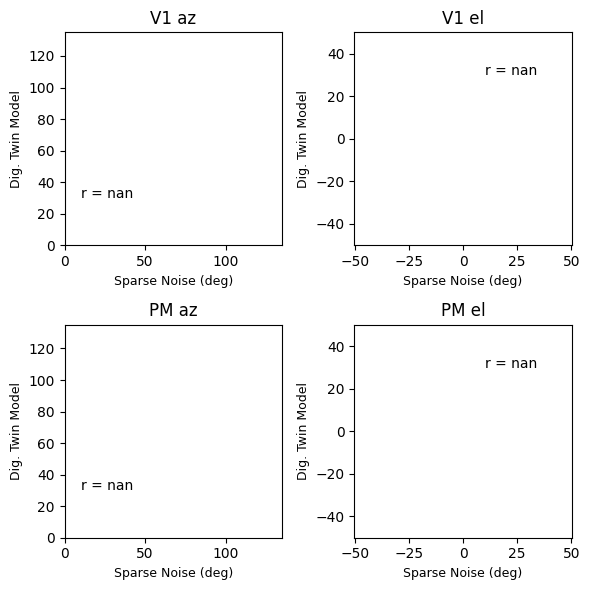

In [3]:
fig,axes     = plt.subplots(2,2,figsize=(6,6))
for iarea,area in enumerate(areas):
    for ispat_dim,spat_dim in enumerate(spat_dims):
        idx         = (sessions[0].celldata['roi_name'] == area) & (sessions[0].celldata['rf_r2_' + rf_type] < sig_thr)
        x           = sessions[0].celldata['rf_' + spat_dim + '_' + rf_type][idx]
        y           = sessions[0].celldata['rf_' + spat_dim + '_' + rf_type_twin][idx]

        sns.scatterplot(ax=axes[iarea,ispat_dim],x=x,y=y,s=7,c=clrs_areas[iarea],alpha=0.5)
        axes[iarea,ispat_dim].set_title(area + ' ' + spat_dim,fontsize=12)
        axes[iarea,ispat_dim].set_xlabel('Sparse Noise (deg)',fontsize=9)
        axes[iarea,ispat_dim].set_ylabel('Dig. Twin Model',fontsize=9)
        if spat_dim == 'az':
            axes[iarea,ispat_dim].set_xlim([0,135])
            axes[iarea,ispat_dim].set_ylim([0,135])
            # axes[iarea,ispat_dim].set_ylim([-0.5,0.5])
        elif spat_dim == 'el':
            axes[iarea,ispat_dim].set_xlim([-50.2,50.2])
            axes[iarea,ispat_dim].set_ylim([-50.2,50.2])
            # axes[iarea,ispat_dim].set_ylim([-0.5,0.5])
        idx = (~np.isnan(x)) & (~np.isnan(y))
        x =  x[idx]
        y =  y[idx]
        # axes[iarea,ispat_dim].text(x=0,y=0.1,s='r = ' + str(np.round(np.corrcoef(x,y)[0,1],3),))
        axes[iarea,ispat_dim].text(x=10,y=30,s='r = ' + str(np.round(np.corrcoef(x,y)[0,1],3),))
plt.tight_layout()
# fig.savefig(os.path.join(savedir,'Alignment_TwinGaussMean_RF_%s_%s' % (rf_type,sessions[0].sessiondata['session_id'][0]) + '.png'), format = 'png')
fig.show()

In [4]:
sessions[0].celldata

,iscell,iscell_prob,skew,radius,npix_soma,npix,xloc,...,rf_az_F,rf_el_F,rf_sz_F,rf_p_F,rf_az_Ftwin,rf_el_Ftwin,rf_p_Ftwin


In [ ]:

#%% Save session rf cell data as a copy to preserve estimated rf from sparse noise mapping
old_celldata    = pd.DataFrame({'rf_az_F': sessions[0].celldata['rf_az_F'],
                                 'rf_el_F': sessions[0].celldata['rf_el_F'], 
                                 'rf_r2_F': sessions[0].celldata['rf_r2_F'] })

#%% Save session rf cell data as a copy to preserve estimated rf from sparse noise mapping
old_celldata    = pd.DataFrame({'rf_az_F': sessions[0].celldata['rf_az_Fneu'],
                                 'rf_el_F': sessions[0].celldata['rf_el_Fneu'], 
                                 'rf_r2_F': sessions[0].celldata['rf_r2_Fneu'] })

#%% Get response-triggered frame for cells and then estimate receptive field from that:
sessions    = estimate_rf_IM(sessions,show_fig=False)

In [ ]:

sig_thr = 0.001
# rf_type = 'Fsmooth'
rf_type = 'Ftwin'
for ises in range(nSessions):
    fig = plot_rf_plane(sessions[ises].celldata,sig_thr=sig_thr,rf_type=rf_type) 
    fig.savefig(os.path.join(savedir,'V1_PM_plane_TwinModel_%s_%s' % (rf_type,sessions[ises].sessiondata['session_id'][0]) + '.png'), format = 'png')


#%% ########### Plot locations of receptive fields as on the screen ##############################
rf_type = 'Fneu'
# rf_type = 'Ftwin'
for ises in range(nSessions):
    fig = plot_rf_screen(sessions[ises].celldata,sig_thr=sig_thr,rf_type=rf_type) 
    # fig.savefig(os.path.join(savedir,'RF_planes','V1_PM_rf_screen_' + sessions[ises].sessiondata['session_id'][0] +  rf_type + '_smooth.png'), format = 'png')
